# **Convolutional Encoding + JPEG Simulation**

## Specifications

### Introduction

This notebook demonstrates the process of encoding and decoding an image using the JPEG algorithm. The steps include Discrete Cosine Transform (DCT), quantization, Huffman encoding, and run-length encoding for the encoding process, and the reverse for the decoding process.

Here's a general outline of implementation:

1. **DCT (Discrete Cosine Transform)**: The `dct` function in the `encoder` module likely transforms each 8x8 block of the image from the spatial domain to the frequency domain. This separates the high-frequency and low-frequency information in the block.

2. **Quantization**: The `quantize` function in the `encoder` module likely divides the DCT coefficients by a quantization matrix, which applies more compression to the high-frequency components. This is the lossy part of the compression.

3. **Run-Length Encoding**: The `run_length_encoding` function in the `encoder` module likely encodes the quantized coefficients using run-length encoding to reduce the size.

4. **Huffman Encoding**: The `huffman_encode` function in the `encoder` module likely encodes the run-length encoded coefficients using Huffman coding to further reduce the size.

5. **File Writing**: The encoded data is likely written to a file along with a header containing information needed to decompress the image.

For decompression, these steps are performed in reverse order:

1. **File Reading**: The compressed data and header are read from the file.

2. **Huffman Decoding**: The `huffman_decode` function in the `decoder` module likely decodes the Huffman encoded data.

3. **Run-Length Decoding**: The `run_length_decoding` function in the `decoder` module likely decodes the run-length encoded data.

4. **Dequantization**: The `dequantize` function in the `decoder` module likely multiplies the run-length decoded data by the quantization matrix to recover the DCT coefficients.

5. **IDCT (Inverse Discrete Cosine Transform)**: The `idct` function in the `decoder` module likely transforms each 8x8 block of the image from the frequency domain back to the spatial domain.

6. **Image Reconstruction**: The `reconstruct_image` function in the `decoder` module likely reconstructs the image from the 8x8 blocks.


## Import necessary modules

We are importing various modules from our encoder and decoder packages. These modules will help us in performing DCT, quantization, Huffman encoding, run-length encoding, and their inverse operations.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import importlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import src.encoder.dct as enc_dct
import src.encoder.read_image as enc_read
import src.encoder.quantize as enc_quantize
import src.encoder.huffman_encode as enc_huff
import src.encoder.run_length_encoding as enc_rle
import src.encoder.transform_1d as enc_trans1d
import src.decoder.huffman_decode as dec_huff
import src.decoder.run_length_decoding as dec_rle
import src.decoder.transform_2d as dec_trans2d
import src.decoder.idct as dec_idct
import src.decoder.reconstruct_image as dec_recon
import src.decoder.dequantize as dec_dequantize
import src.utils.compare_images as utils_comp
import src.encoder.convolutional_encoder as enc_conv
import src.decoder.viterbi_decoder as dec_viterbi
import src.utils.awgn as add_awgn_noise
import src.utils.ber_snr as calculate_ber_snr


In [3]:
# Reload the modules
importlib.reload(enc_dct)
importlib.reload(enc_read)
importlib.reload(enc_quantize)
importlib.reload(enc_huff)
importlib.reload(enc_rle)
importlib.reload(enc_trans1d)
importlib.reload(dec_huff)
importlib.reload(dec_rle)
importlib.reload(dec_trans2d)
importlib.reload(dec_idct)
importlib.reload(dec_recon)
importlib.reload(dec_dequantize)
importlib.reload(utils_comp)
importlib.reload(enc_conv)
importlib.reload(dec_viterbi)
importlib.reload(add_awgn_noise)
importlib.reload(calculate_ber_snr)

<module 'src.utils.ber_snr' from 'd:\\Repos\\JPEG-Encoder-Decoder\\src\\utils\\ber_snr.py'>

In [4]:

from src.encoder.dct import Block8_DCT
from src.encoder.read_image import read_image
from src.encoder.quantize import QuantizationTable
from src.encoder.quantize import quantize
from src.encoder.huffman_encode import huffman_encode
from src.encoder.run_length_encoding import run_length_encode
from src.encoder.transform_1d import serpentine_scan
from src.decoder.huffman_decode import huffman_decode
from src.decoder.run_length_decoding import run_length_decode
from src.decoder.transform_2d import serpentine_scan_reverse
from src.decoder.idct import Block8_IDCT
from src.decoder.reconstruct_image import reconstruct_image
from src.decoder.dequantize import dequantize
from src.utils.compare_images import compare_images
from src.encoder.convolutional_encoder import ConvolutionalEncoder
from src.decoder.viterbi_decoder import ViterbiDecoder
from src.utils.awgn import add_awgn_noise
from src.utils.ber_snr import calculate_ber, calculate_snr, plot_ber_vs_snr


## Loading the image

We are loading an image from our data set to demonstrate the encoding and decoding process. This particular image was chosen because it has a required specifications of being gray-scale image.

In [5]:
# Load image path
load_image_path = '../data/raw/cat_raw.jpg'

# Extract the filename from the path
filename = os.path.basename(load_image_path)

# Remove the extension
image_name = os.path.splitext(filename)[0]

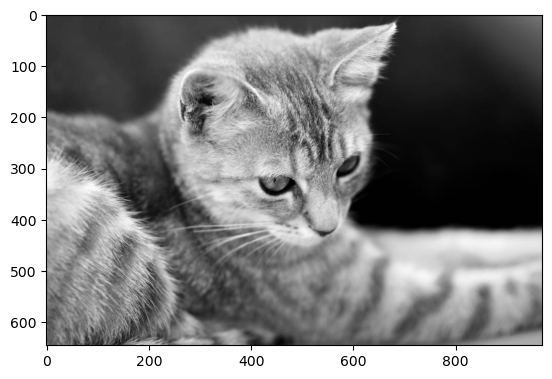

In [6]:


def load_image(file_path):
    img = Image.open(file_path).convert('L')
    return img

img = load_image(load_image_path)

# Plot the image
plt.imshow(img, cmap='gray')
plt.show()

In [7]:
import imageio

# Step 1: Load the original image
original_image = imageio.imread(load_image_path)

# Step 2: Get the number of rows and columns
rows, cols = original_image.shape[0] // 8, original_image.shape[1] // 8

C:\Users\Lord MZ\AppData\Local\Temp\ipykernel_29440\155663793.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(load_image_path)


## Encoding

In [8]:
# Step 1: Read the image and divide it into 8x8 blocks
blocks, original_shape = read_image(load_image_path)


In [9]:
print(blocks.shape,blocks[0].shape)

(9882, 8, 8) (8, 8)


In [10]:

image_reconstruct_test = reconstruct_image(blocks, original_shape)


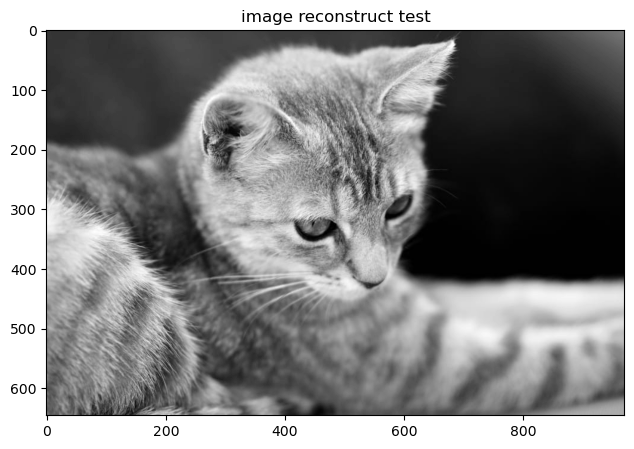

In [11]:

# Step 13: Preview the images
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
plt.imshow(image_reconstruct_test, cmap='gray')
plt.title('image reconstruct test') 


plt.show()

### Performing DCT

We start the encoding process by performing a Discrete Cosine Transform (DCT) on the image. This transforms the image from the spatial domain to the frequency domain, separating the high-frequency and low-frequency information.

In [12]:

# Step 2: Perform DCT on each block
dct_blocks = np.array([Block8_DCT(block) for block in blocks])



In [13]:
dct_blocks.shape

(9882, 8, 8)

In [14]:
blocks[27]

array([[71, 71, 71, 71, 71, 71, 71, 71],
       [72, 72, 72, 72, 72, 72, 72, 72],
       [72, 72, 72, 72, 72, 72, 72, 72],
       [72, 72, 72, 72, 72, 72, 72, 72],
       [73, 73, 73, 73, 73, 73, 73, 73],
       [73, 73, 73, 73, 73, 73, 73, 73],
       [73, 73, 73, 73, 73, 73, 73, 73],
       [74, 74, 74, 74, 74, 74, 74, 74]], dtype=uint8)

In [15]:
dct_blocks[27]

array([[ 7.25000000e+01,  1.42108547e-14, -7.10542736e-15,
         7.10542736e-15,  1.77635684e-15,  3.19744231e-14,
        -2.30926389e-14, -1.42108547e-14],
       [-1.13112150e+00, -5.55111512e-16, -3.10862447e-15,
         1.55431223e-15, -1.77635684e-15,  1.44328993e-15,
        -1.33226763e-15, -2.66453526e-15],
       [-7.10542736e-15,  2.22044605e-16,  1.77635684e-15,
         0.00000000e+00, -4.44089210e-16,  5.55111512e-16,
         4.44089210e-16, -1.88737914e-15],
       [-1.90740750e-01, -5.55111512e-16, -2.22044605e-16,
        -3.33066907e-16, -4.44089210e-16, -1.44328993e-15,
        -1.33226763e-15,  1.44328993e-15],
       [ 1.77635684e-15,  5.55111512e-16, -4.44089210e-16,
         3.33066907e-16,  1.33226763e-15, -1.55431223e-15,
        -2.22044605e-16,  4.44089210e-16],
       [-4.28121338e-01,  3.33066907e-16, -8.88178420e-16,
        -7.21644966e-16, -1.33226763e-15,  1.66533454e-15,
        -3.33066907e-16,  1.11022302e-16],
       [-1.95399252e-14, -4.996003

In [16]:
# Step 3: Perform the quantization step per 8x8 block
q_blocks_low = quantize(dct_blocks, 'low')
q_blocks_high = quantize(dct_blocks, 'high')


In [17]:
q_blocks_low.shape , q_blocks_high.shape

((9882, 8, 8), (9882, 8, 8))

In [18]:
q_blocks_low[27]

array([[ 7.25000000e+01,  1.42108547e-14, -7.10542736e-15,
         7.10542736e-15,  1.77635684e-15,  1.59872116e-14,
        -1.15463195e-14, -3.55271368e-15],
       [-1.13112150e+00, -5.55111512e-16, -3.10862447e-15,
         1.55431223e-15, -1.77635684e-15,  7.21644966e-16,
        -6.66133815e-16, -6.66133815e-16],
       [-7.10542736e-15,  2.22044605e-16,  1.77635684e-15,
         0.00000000e+00, -2.22044605e-16,  2.77555756e-16,
         2.22044605e-16, -4.71844785e-16],
       [-1.90740750e-01, -5.55111512e-16, -2.22044605e-16,
        -3.33066907e-16, -2.22044605e-16, -7.21644966e-16,
        -3.33066907e-16,  1.80411242e-16],
       [ 1.77635684e-15,  5.55111512e-16, -2.22044605e-16,
         1.66533454e-16,  6.66133815e-16, -7.77156117e-16,
        -5.55111512e-17,  5.55111512e-17],
       [-2.14060669e-01,  1.66533454e-16, -4.44089210e-16,
        -3.60822483e-16, -6.66133815e-16,  4.16333634e-16,
        -4.16333634e-17,  1.38777878e-17],
       [-9.76996262e-15, -2.498001

In [19]:
# Step 4: Transform each block from 2-D into 1-D vector
transformed_blocks_low = np.array([serpentine_scan(block) for block in q_blocks_low if block.shape == (8, 8)])
transformed_blocks_high = np.array([serpentine_scan(block) for block in q_blocks_high if block.shape == (8, 8)])

In [20]:
transformed_blocks_low.shape , transformed_blocks_high.shape

((9882, 64), (9882, 64))

In [21]:
transformed_blocks_low[27]

array([ 7.25000000e+01,  1.42108547e-14, -1.13112150e+00, -7.10542736e-15,
       -5.55111512e-16, -7.10542736e-15,  7.10542736e-15, -3.10862447e-15,
        2.22044605e-16, -1.90740750e-01,  1.77635684e-15, -5.55111512e-16,
        1.77635684e-15,  1.55431223e-15,  1.77635684e-15,  1.59872116e-14,
       -1.77635684e-15,  0.00000000e+00, -2.22044605e-16,  5.55111512e-16,
       -2.14060669e-01, -9.76996262e-15,  1.66533454e-16, -2.22044605e-16,
       -3.33066907e-16, -2.22044605e-16,  7.21644966e-16, -1.15463195e-14,
       -3.55271368e-15, -6.66133815e-16,  2.77555756e-16, -2.22044605e-16,
        1.66533454e-16, -4.44089210e-16, -2.49800181e-16,  7.47593344e-03,
       -2.84494650e-16, -3.88578059e-16, -3.60822483e-16,  6.66133815e-16,
       -7.21644966e-16,  2.22044605e-16, -6.66133815e-16, -4.71844785e-16,
       -3.33066907e-16, -7.77156117e-16, -6.66133815e-16, -1.11022302e-16,
        2.77555756e-17, -4.16333634e-17,  1.11022302e-16,  4.16333634e-16,
       -5.55111512e-17,  

In [22]:
# Step 5: Run-length encode
run_length_encoded_blocks_low = [run_length_encode(block) for block in transformed_blocks_low]
run_length_encoded_blocks_high = [run_length_encode(block) for block in transformed_blocks_high]


In [23]:
print(len(run_length_encoded_blocks_low))

9882


In [24]:
run_length_encoded_blocks_low[27]

array([[ 7.25000000e+01,  1.00000000e+00],
       [ 1.42108547e-14,  1.00000000e+00],
       [-1.13112150e+00,  1.00000000e+00],
       [-7.10542736e-15,  1.00000000e+00],
       [-5.55111512e-16,  1.00000000e+00],
       [-7.10542736e-15,  1.00000000e+00],
       [ 7.10542736e-15,  1.00000000e+00],
       [-3.10862447e-15,  1.00000000e+00],
       [ 2.22044605e-16,  1.00000000e+00],
       [-1.90740750e-01,  1.00000000e+00],
       [ 1.77635684e-15,  1.00000000e+00],
       [-5.55111512e-16,  1.00000000e+00],
       [ 1.77635684e-15,  1.00000000e+00],
       [ 1.55431223e-15,  1.00000000e+00],
       [ 1.77635684e-15,  1.00000000e+00],
       [ 1.59872116e-14,  1.00000000e+00],
       [-1.77635684e-15,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00],
       [-2.22044605e-16,  1.00000000e+00],
       [ 5.55111512e-16,  1.00000000e+00],
       [-2.14060669e-01,  1.00000000e+00],
       [-9.76996262e-15,  1.00000000e+00],
       [ 1.66533454e-16,  1.00000000e+00],
       [-2.

In [25]:
len(run_length_encoded_blocks_low)

9882

### Huffman Encoding

We continue the encoding process by performing Huffman encoding on the run-length encoded data. This step converts the run-length encoded data into a more compact form, further reducing the size of the data.

In [26]:
# Step 6: Huffman encode
huffman_encoded_blocks_low = []
huff_dict_low = []
for block in run_length_encoded_blocks_low:
    encoded_block, huff_dict = huffman_encode(block)
    huffman_encoded_blocks_low.append(encoded_block)
    huff_dict_low.append(huff_dict)

huffman_encoded_blocks_high = []
huff_dict_high = []
for block in run_length_encoded_blocks_high:
    encoded_block, huff_dict = huffman_encode(block)
    huffman_encoded_blocks_high.append(encoded_block)
    huff_dict_high.append(huff_dict)

In [27]:
# Debug cell for huffman_encoded_blocks_low and huffman_encoded_blocks_high sizes
print("Size of huffman_encoded_blocks_low:", len(huffman_encoded_blocks_low))
print("Size of huffman_encoded_blocks_high:", len(huffman_encoded_blocks_high))
print("Size of huffman_encoded_blocks_low[0]:", len(huffman_encoded_blocks_low[0]))
print("Size of huffman_encoded_blocks_high[0]:", len(huffman_encoded_blocks_high[0]))


Size of huffman_encoded_blocks_low: 9882
Size of huffman_encoded_blocks_high: 9882
Size of huffman_encoded_blocks_low[0]: 62
Size of huffman_encoded_blocks_high[0]: 59


In [28]:
huffman_encoded_blocks_low[27]

['111101',
 '111010',
 '000100',
 '00101',
 '01000',
 '00101',
 '111001',
 '001100',
 '11000',
 '000110',
 '0000',
 '01000',
 '0000',
 '111000',
 '0000',
 '111011',
 '001101',
 '100110',
 '0111',
 '110101',
 '000101',
 '001000',
 '10111',
 '0111',
 '01011',
 '0111',
 '110111',
 '000111',
 '001001',
 '11111',
 '110011',
 '0111',
 '10111',
 '010011',
 '01101',
 '111100',
 '011000',
 '010100',
 '010101',
 '110110',
 '001111',
 '11000',
 '11111',
 '010010',
 '01011',
 '001110',
 '11111',
 '011001',
 '101000',
 '10001',
 '101100',
 '110100',
 '10000',
 '101101',
 '10101',
 '10001',
 '110010',
 '10101',
 '100100',
 '01101',
 '100111',
 '100101',
 '101001',
 '10000']

In [29]:
len(huffman_encoded_blocks_low),len(huffman_encoded_blocks_low[27])

(9882, 64)

In [30]:
# Step 16: Use the convolutional encoder on the Huffman encoded blocks
encoder = ConvolutionalEncoder()
encoded_blocks_low = encoder.encode(huffman_encoded_blocks_low)
encoded_blocks_high = encoder.encode(huffman_encoded_blocks_high)


In [31]:
# Get your encoded blocks
encoded_blocks_low = np.array(encoded_blocks_low)  
encoded_blocks_high = np.array(encoded_blocks_high) 

In [32]:
encoded_blocks_low.shape , encoded_blocks_high.shape

((1946787,), (1946352,))

In [33]:
# Define your SNR values
snr_values = [10, 20, 30]  # Replace with your actual SNR values

In [34]:
# Create dictionaries to store the transmitted signals

transmitted_signals_low = {}
transmitted_signals_high = {}

# Add AWGN noise to the encoded blocks for each SNR value
for snr in snr_values:
    transmitted_signals_low[f'snr_{snr}'] = add_awgn_noise(encoded_blocks_low, snr)
    transmitted_signals_high[f'snr_{snr}'] = add_awgn_noise(encoded_blocks_high, snr)

    # Print the size and a few elements of the transmitted signals
    print(f"SNR: {snr}, Transmitted signals low size: {len(transmitted_signals_low[f'snr_{snr}'])}, First few elements: {transmitted_signals_low[f'snr_{snr}'][:10]}")
    print(f"SNR: {snr}, Transmitted signals high size: {len(transmitted_signals_high[f'snr_{snr}'])}, First few elements: {transmitted_signals_high[f'snr_{snr}'][:10]}")

SNR: 10, Transmitted signals low size: 1946787, First few elements: [ -1027  -2163  -1941   1676 112750  -2017 111151  -1520   -245 112821]
SNR: 10, Transmitted signals high size: 1946352, First few elements: [ -762 -2314 -3817 -2648 -3765 -3338 -4462   -54  4217  -284]
SNR: 20, Transmitted signals low size: 1946787, First few elements: [   597   -537    598    465 110001   -882 111896   -932    575 111350]
SNR: 20, Transmitted signals high size: 1946352, First few elements: [ -384   343  -127 -1149  -146   -99  -756  -590    51   582]
SNR: 30, Transmitted signals low size: 1946787, First few elements: [  -324    321     53    344 110593     -3 111267   -233    342 110962]
SNR: 30, Transmitted signals high size: 1946352, First few elements: [ 133  200  287  -76 -108  -52  303  337 -155 -118]


## Decoding


JPEG Decoding Process:

The decoding process is essentially the reverse of the encoding process. It involves the following steps:

1. **Huffman Decoding**: We start the decoding process by performing Huffman decoding on the encoded data. This recovers the run-length encoded data from the Huffman encoded data.

2. **Run-Length Decoding**: The run-length encoded data is then decoded to recover the quantized DCT coefficients.

3. **Dequantization**: The quantized DCT coefficients are multiplied by the quantization matrix to recover the original DCT coefficients.

4. **Inverse DCT**: The Inverse Discrete Cosine Transform (IDCT) is applied to each 8x8 block of DCT coefficients to transform it back to the spatial domain.

5. **Image Reconstruction**: Finally, the image is reconstructed from the 8x8 blocks to produce the final output image.

Throughout this process, we'll be using the functions provided in our `decoder` module.

In [35]:
#step 17: Define your Viterbi decoder
# Instantiate the ViterbiDecoder
viterbi_decoder = ViterbiDecoder()

# Create dictionaries to store the decoded signals
decoded_signals_low = {}
decoded_signals_high = {}

# Decode the transmitted signals for each SNR value
for snr in snr_values:
    decoded_signals_low[f'snr_{snr}'] = viterbi_decoder.decode(transmitted_signals_low[f'snr_{snr}'])
    decoded_signals_high[f'snr_{snr}'] = viterbi_decoder.decode(transmitted_signals_high[f'snr_{snr}'])

    # Print the size and a few elements of the decoded signals
    print(f"SNR: {snr}, Decoded signals low size: {len(decoded_signals_low[f'snr_{snr}'])}, First few elements: {decoded_signals_low[f'snr_{snr}'][:10]}")
    print(f"SNR: {snr}, Decoded signals high size: {len(decoded_signals_high[f'snr_{snr}'])}, First few elements: {decoded_signals_high[f'snr_{snr}'][:10]}")

SNR: 10, Decoded signals low size: 648927, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 10, Decoded signals high size: 1297711, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 20, Decoded signals low size: 1946640, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 20, Decoded signals high size: 2595424, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 30, Decoded signals low size: 3244353, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 30, Decoded signals high size: 3893137, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [36]:
# Step 7: Huffman decode
# Create dictionaries to store the Huffman decoded signals
huffman_decoded_signals_low = {}
huffman_decoded_signals_high = {}

# Decode the Viterbi decoded signals for each SNR value
for snr in snr_values:
    # Convert the decoded bits back into Huffman symbols
    huffman_symbols_low = ''.join(map(str, decoded_signals_low[f'snr_{snr}']))
    huffman_symbols_high = ''.join(map(str, decoded_signals_high[f'snr_{snr}']))

    # Decode the Huffman symbols
    huffman_decoded_signals_low[f'snr_{snr}'] = huffman_decode([huffman_symbols_low], [huff_dict_low[0]])[0]
    huffman_decoded_signals_high[f'snr_{snr}'] = huffman_decode([huffman_symbols_high], [huff_dict_high[0]])[0]

    # Print the size and a few elements of the Huffman decoded signals
    print(f"SNR: {snr}, Huffman decoded signals low size: {len(huffman_decoded_signals_low[f'snr_{snr}'])}, First few elements: {huffman_decoded_signals_low[f'snr_{snr}'][:10]}")
    print(f"SNR: {snr}, Huffman decoded signals high size: {len(huffman_decoded_signals_high[f'snr_{snr}'])}, First few elements: {huffman_decoded_signals_high[f'snr_{snr}'][:10]}")

SNR: 10, Huffman decoded signals low size: 116124, First few elements: [[-1.72084569e-15  1.00000000e+00]
 [ 7.10542736e-15  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [-6.10622664e-16  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [-1.72084569e-15  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [-1.72084569e-15  1.00000000e+00]
 [-6.93889390e-18  1.00000000e+00]
 [ 5.40000000e+01  1.00000000e+00]]
SNR: 10, Huffman decoded signals high size: 229130, First few elements: [[-3.10862447e-15  1.00000000e+00]
 [ 1.38777878e-16  1.00000000e+00]
 [-3.46944695e-18  1.00000000e+00]
 [-4.33680869e-18  1.00000000e+00]
 [-5.20417043e-18  1.00000000e+00]
 [-3.10862447e-15  1.00000000e+00]
 [-3.46944695e-18  1.00000000e+00]
 [-1.38777878e-17  1.00000000e+00]
 [ 5.32907052e-15  1.00000000e+00]
 [-5.20417043e-18  1.00000000e+00]]
SNR: 20, Huffman decoded signals low size: 348316, First few elements: [[-1.72084569e-15  1.00000000e+00]
 [ 7.10542736e-15  1.00000000e+00]
 [ 0.00000000e

In [37]:
# Step 8: Run-length decode
run_length_decoded_signals_low = {}
run_length_decoded_signals_high = {}

for snr, signal in huffman_decoded_signals_low.items():
    # Flatten the 2D array or list of lists
    flattened_signal = [item for sublist in signal for item in sublist]
    # Convert flattened array to list of tuples
    signal_as_list = [tuple(flattened_signal[i:i+2]) for i in range(0, len(flattened_signal), 2)]
    print(f"SNR: {snr}, Length of signal as list of tuples: {len(signal_as_list)}")
    run_length_decoded_signals_low[snr] = run_length_decode(signal_as_list)
    print(f"SNR: {snr}, Length of run-length decoded signal: {len(run_length_decoded_signals_low[snr])}")

for snr, signal in huffman_decoded_signals_high.items():
    # Flatten the 2D array or list of lists
    flattened_signal = [item for sublist in signal for item in sublist]
    # Convert flattened array to list of tuples
    signal_as_list = [tuple(flattened_signal[i:i+2]) for i in range(0, len(flattened_signal), 2)]
    print(f"SNR: {snr}, Length of signal as list of tuples: {len(signal_as_list)}")
    run_length_decoded_signals_high[snr] = run_length_decode(signal_as_list)
    print(f"SNR: {snr}, Length of run-length decoded signal: {len(run_length_decoded_signals_high[snr])}")

SNR: snr_10, Length of signal as list of tuples: 116124
SNR: snr_10, Length of run-length decoded signal: 116756
SNR: snr_20, Length of signal as list of tuples: 348316
SNR: snr_20, Length of run-length decoded signal: 350156
SNR: snr_30, Length of signal as list of tuples: 580465
SNR: snr_30, Length of run-length decoded signal: 583185
SNR: snr_10, Length of signal as list of tuples: 229130
SNR: snr_10, Length of run-length decoded signal: 230409
SNR: snr_20, Length of signal as list of tuples: 458237
SNR: snr_20, Length of run-length decoded signal: 460259
SNR: snr_30, Length of signal as list of tuples: 687409
SNR: snr_30, Length of run-length decoded signal: 690005


In [38]:
#step 17: Define your Viterbi decoder
# Instantiate the ViterbiDecoder
viterbi_decoder = ViterbiDecoder()

# Create dictionaries to store the decoded signals
decoded_signals_low = {}
decoded_signals_high = {}

# Decode the transmitted signals for each SNR value
for snr in snr_values:
    decoded_signals_low[f'snr_{snr}'] = viterbi_decoder.decode(transmitted_signals_low[f'snr_{snr}'])
    decoded_signals_high[f'snr_{snr}'] = viterbi_decoder.decode(transmitted_signals_high[f'snr_{snr}'])

    # Print the size and a few elements of the decoded signals
    print(f"SNR: {snr}, Decoded signals low size: {len(decoded_signals_low[f'snr_{snr}'])}, First few elements: {decoded_signals_low[f'snr_{snr}'][:10]}")
    print(f"SNR: {snr}, Decoded signals high size: {len(decoded_signals_high[f'snr_{snr}'])}, First few elements: {decoded_signals_high[f'snr_{snr}'][:10]}")

SNR: 10, Decoded signals low size: 648927, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 10, Decoded signals high size: 1297711, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 20, Decoded signals low size: 1946640, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 20, Decoded signals high size: 2595424, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 30, Decoded signals low size: 3244353, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
SNR: 30, Decoded signals high size: 3893137, First few elements: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [39]:
# Step 9: Transform 1-D vector into groups of 8x8 matrices
transformed_blocks_low = {}
transformed_blocks_high = {}

for snr in snr_values:
    # Pad the decoded signals to make their lengths multiples of 64
    padded_decoded_signals_low = decoded_signals_low[f'snr_{snr}'] + [0] * (64 - len(decoded_signals_low[f'snr_{snr}']) % 64)
    padded_decoded_signals_high = decoded_signals_high[f'snr_{snr}'] + [0] * (64 - len(decoded_signals_high[f'snr_{snr}']) % 64)

    # Transform the padded decoded signals into 8x8 matrices
    transformed_blocks_low[f'snr_{snr}'] = [serpentine_scan_reverse(padded_decoded_signals_low[i:i+64]) for i in range(0, len(padded_decoded_signals_low), 64)]
    transformed_blocks_high[f'snr_{snr}'] = [serpentine_scan_reverse(padded_decoded_signals_high[i:i+64]) for i in range(0, len(padded_decoded_signals_high), 64)]

In [40]:
# Get the low and high quantization tables
q_table_low = QuantizationTable('low')
q_table_high = QuantizationTable('high')

In [41]:
# Step 10: Multiply each group by the quantization tables
# Dequantize the blocks
dequantized_blocks_low = {}
dequantized_blocks_high = {}

# When creating the blocks
for snr, blocks in transformed_blocks_low.items():
    print(f"SNR: {snr}, Number of blocks before dequantization: {len(blocks)}")
    dequantized_blocks_low[snr] = [dequantize(block, q_table_low) for block in blocks]

for snr, blocks in transformed_blocks_high.items():
    print(f"SNR: {snr}, Number of blocks before dequantization: {len(blocks)}")
    dequantized_blocks_high[snr] = [dequantize(block, q_table_high) for block in blocks]

SNR: snr_10, Number of blocks before dequantization: 10140
SNR: snr_20, Number of blocks before dequantization: 30417
SNR: snr_30, Number of blocks before dequantization: 50694
SNR: snr_10, Number of blocks before dequantization: 20277
SNR: snr_20, Number of blocks before dequantization: 40554
SNR: snr_30, Number of blocks before dequantization: 60831


In [56]:
# Step 11: Apply the IDCT to each 8x8 block

idct_blocks_low = {}
idct_blocks_high = {}

for snr, blocks in dequantized_blocks_low.items():
    blocks_array = np.array(blocks)
    idct_blocks_low[f'snr_{snr}'] = [Block8_IDCT(blocks_array[i:i+8, j:j+8]) for i in range(0, blocks_array.shape[0], 8) for j in range(0, blocks_array.shape[1], 8)]

for snr, blocks in dequantized_blocks_high.items():
    blocks_array = np.array(blocks)
    idct_blocks_high[f'snr_{snr}'] = [Block8_IDCT(blocks_array[i:i+8, j:j+8]) for i in range(0, blocks_array.shape[0], 8) for j in range(0, blocks_array.shape[1], 8)]

ValueError: too many values to unpack (expected 2)

In [48]:
# Step 13: Combine the 8x8 blocks into a single image
reconstructed_images_low = {}
reconstructed_images_high = {}

# Print the sizes of the initial dictionaries
print(f"Size of idct_blocks_low: {len(idct_blocks_low)}")
print(f"Size of idct_blocks_high: {len(idct_blocks_high)}")

for snr, blocks in idct_blocks_low.items():
    # Print the size of each blocks list
    print(f"SNR: {snr}, Number of blocks: {len(blocks)}, Expected number of blocks: {(original_shape[0]//8)*(original_shape[1]//8)}")
    reconstructed_images_low[snr] = reconstruct_image(blocks, original_shape)
    # Print the size of the reconstructed image
    print(f"Size of reconstructed image (low): {reconstructed_images_low[snr].shape}")

for snr, blocks in idct_blocks_high.items():
    # Print the size of each blocks list
    print(f"SNR: {snr}, Number of blocks: {len(blocks)}, Expected number of blocks: {(original_shape[0]//8)*(original_shape[1]//8)}")
    reconstructed_images_high[snr] = reconstruct_image(blocks, original_shape)
    # Print the size of the reconstructed image
    print(f"Size of reconstructed image (high): {reconstructed_images_high[snr].shape}")

# Print the sizes of the final dictionaries
print(f"Size of reconstructed_images_low: {len(reconstructed_images_low)}")
print(f"Size of reconstructed_images_high: {len(reconstructed_images_high)}")

Size of idct_blocks_low: 0
Size of idct_blocks_high: 0
Size of reconstructed_images_low: 0
Size of reconstructed_images_high: 0


In [45]:
# Plotting images in reconstructed_images_low
for snr, image in reconstructed_images_low.items():
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.title(f"Low SNR: {snr}")
    plt.show()

# Plotting images in reconstructed_images_high
for snr, image in reconstructed_images_high.items():
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.title(f"High SNR: {snr}")
    plt.show()


In [ ]:
# Use the image name in the paths of the resultant images
low_quantization_image_path = f'../data/processed/low_quantization_{image_name}_conv.jpg'
high_quantization_image_path = f'../data/processed/high_quantization_{image_name}_conv.jpg'

In [ ]:
# Save the low-quality image
imageio.imsave(low_quantization_image_path, image_low)

# Save the high-quality image
imageio.imsave(high_quantization_image_path, image_high)

Lossy conversion from float64 to uint8. Range [-8.648724098003768e-14, 255.0000000000004]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [-2254.2142030539258, 2249.9872588149]. Convert image to uint8 prior to saving to suppress this warning.


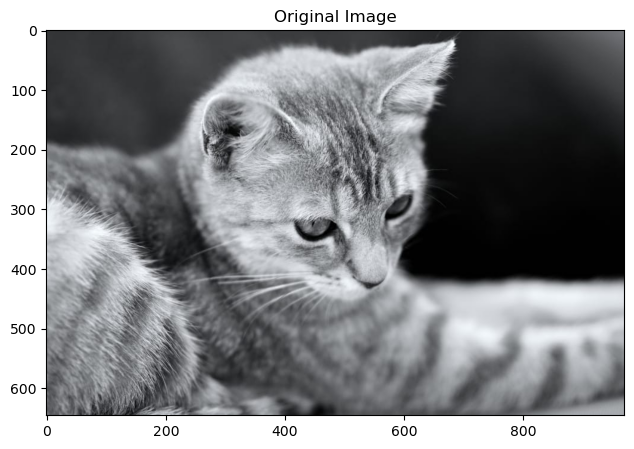

In [46]:
# Plot the original image
plt.figure(figsize=(10, 5))
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.show()

## Compare the original and reconstructed images

We are comparing the original and reconstructed images using Mean Squared Error (MSE), Peak Signal-to-Noise Ratio (PSNR), and compression ratio to evaluate the performance of our JPEG encoder and decoder.

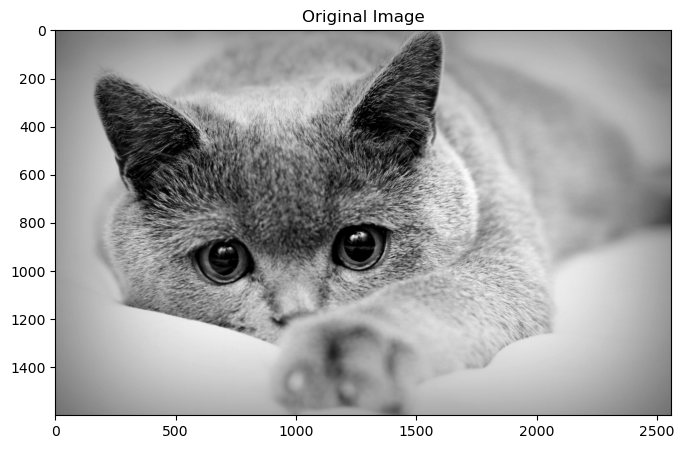

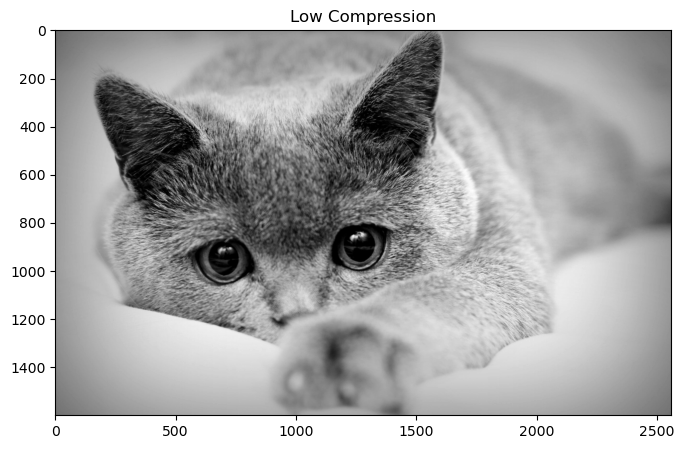

Mean Squared Error between the images: 1.0908586035486283e-26
Peak Signal-to-Noise Ratio: 307.7531189962717
Compression Ratio: 0.9628270879347134


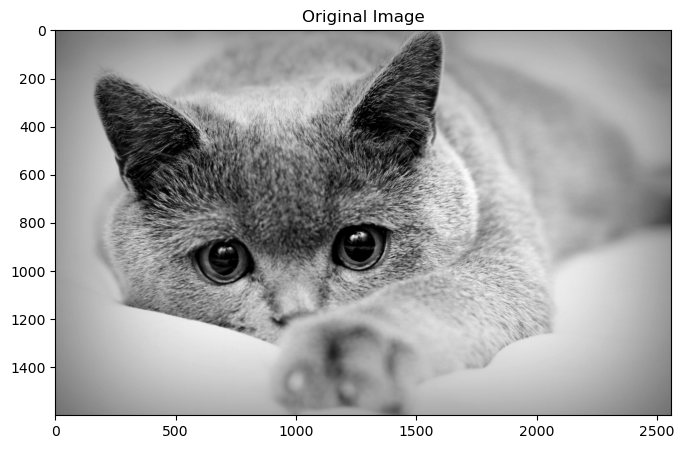

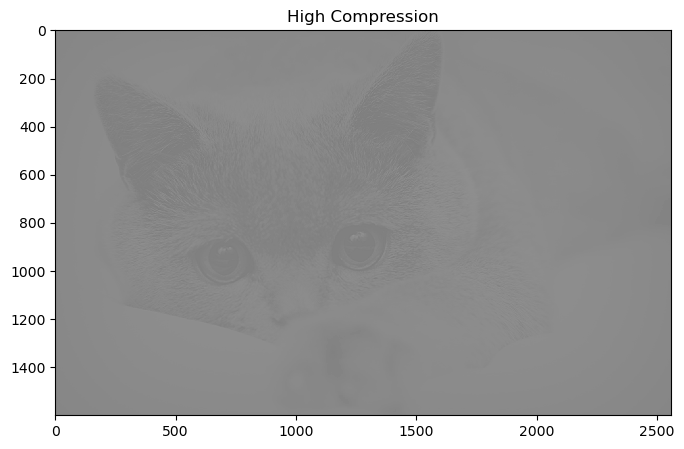

Mean Squared Error between the images: 6707.559789789424
Peak Signal-to-Noise Ratio: 9.865158082962198
Compression Ratio: 0.5911641983591971


In [ ]:
# Step 14: Compare the original image with the low-compressed/high-compressed image
# Compare the images and store the results in a list
results = []
results.append(compare_images(original_image, image_low, load_image_path, low_quantization_image_path, 'Low Compression'))
results.append(compare_images(original_image, image_high, load_image_path, high_quantization_image_path, 'High Compression'))


In [ ]:
import pandas as pd
# Convert the list to a DataFrame
df = pd.DataFrame(results, columns=['Title', 'MSE', 'PSNR', 'Compression Ratio'])

# Print the DataFrame
print(df)

              Title           MSE        PSNR  Compression Ratio
0   Low Compression  1.090859e-26  307.753119           0.962827
1  High Compression  6.707560e+03    9.865158           0.591164


## Choice of Quantization Table

In our JPEG encoder and decoder implementation, we provide two options for the quantization table: 'low' and 'high'. The choice of quantization table significantly impacts the balance between the level of compression and the quality of the reconstructed image.

1. **Low Quantization Table**: This table has lower values, meaning less information is lost during the quantization process. This results in higher quality for the reconstructed image, but less compression. This option is suitable when image quality is a priority over the size of the compressed file.

2. **High Quantization Table**: This table has higher values, meaning more information is lost during the quantization process. This results in lower quality for the reconstructed image, but more compression. This option is suitable when the size of the compressed file is a priority over image quality.

The choice between these two options depends on the specific requirements of the user. If maintaining image quality is paramount, the 'low' option would be the best choice. Conversely, if minimizing storage space is more important, the 'high' option would be more suitable.